In [73]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [74]:
base_dir = os.path.abspath(os.curdir) + r'/data'

df = pd.read_csv(path.join(os.sep, base_dir, 'Exchange Rate TWI May 1970  Aug 1995.csv'))
df = df.rename(columns={"x":"value"})
df.head()

,Unnamed: 0,value
0,1,100.0
1,2,99.6
2,3,99.4
3,4,99.1
4,5,99.2


In [75]:
df.describe()

,Unnamed: 0,value
count,608.00000,608.000000
mean,304.50000,78.600329
std,175.65876,20.531258
min,1.00000,47.300000
25%,152.75000,58.875000
50%,304.50000,82.800000
75%,456.25000,97.900000
max,608.00000,121.300000


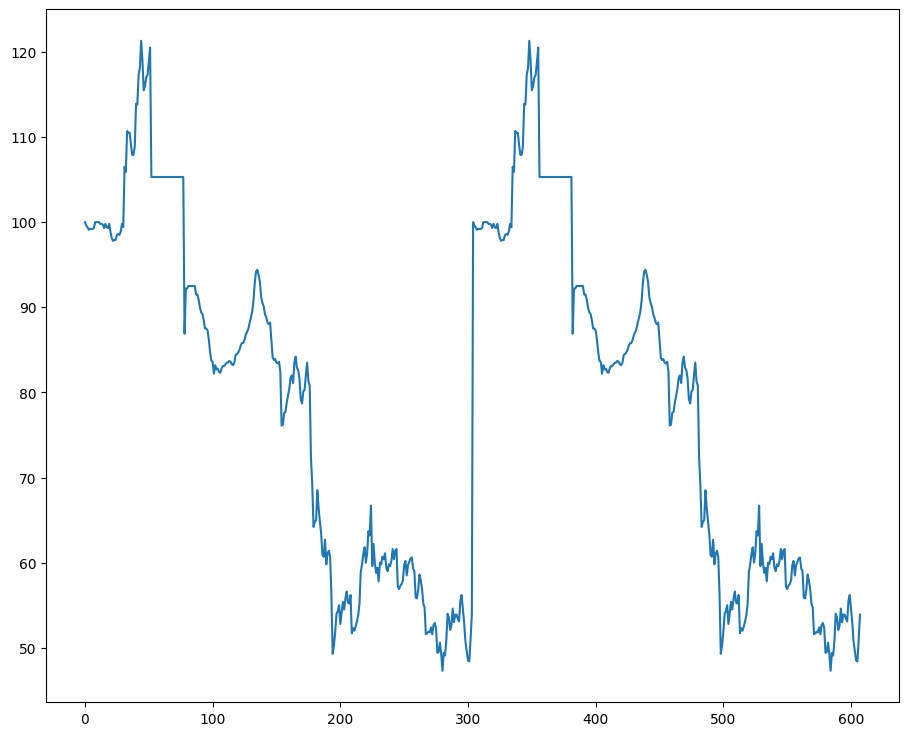

In [76]:
plt.plot(df["value"])

## Проверка стационарности ряда

In [77]:
from statsmodels.tsa.stattools import adfuller

In [78]:
def stationarity_check(time_series, name: str, alpha: float = 0.05):
    """Проверка ряда на стационарность"""
    print(f'Тест Дики-Фуллера ряда {name} :')

    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [79]:
stationarity_check(df["value"], name = "Exchange Rate TWI May 1970  Aug 1995")

Тест Дики-Фуллера ряда Exchange Rate TWI May 1970  Aug 1995 :
Test Statistic                  -1.655297
p-value                          0.454279
#Lags Used                       0.000000
Number of Observations Used    607.000000
Critical Value (1%)             -3.441169
Critical Value (5%)             -2.866313
Critical Value (10%)            -2.569312
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


## Декомпозиция ряда

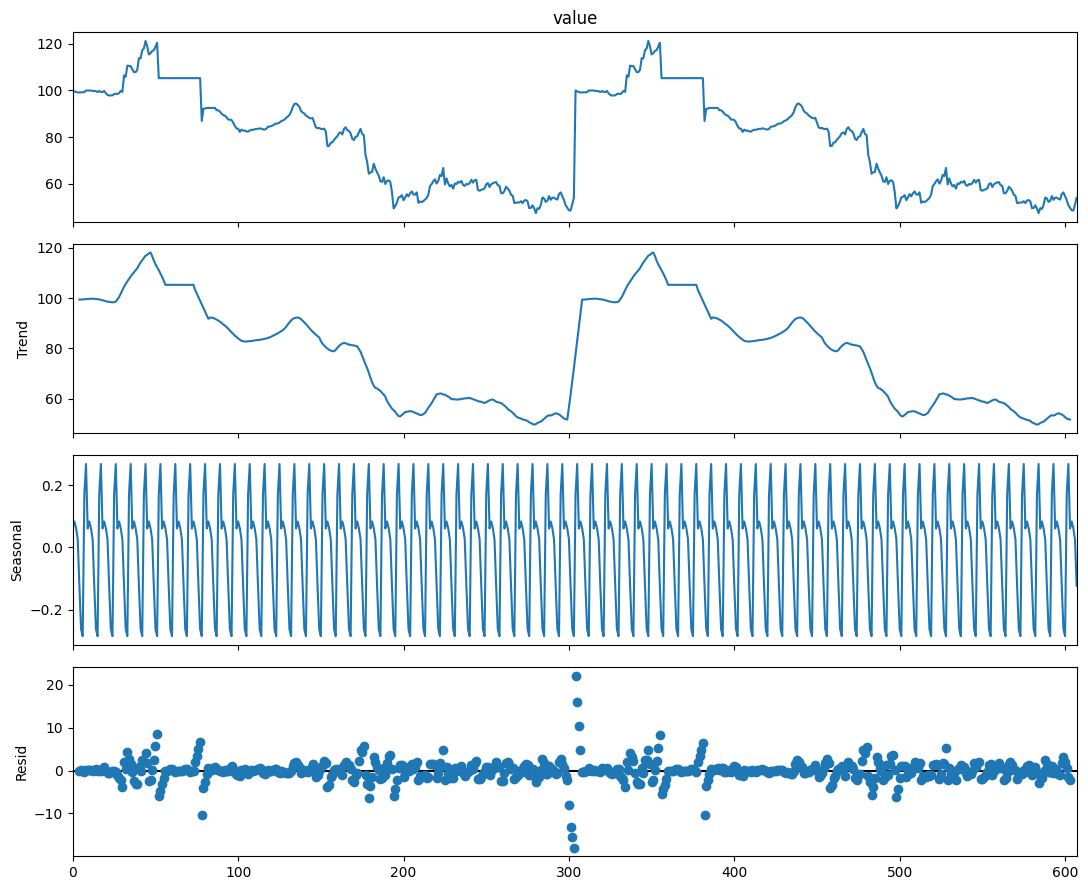

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(df["value"], period=9)
decompose.plot()
plt.show()

In [81]:
def get_ts_without_trend(time_series):
    """Удаление тренда из временного ряда"""
    nottrend = []

    # выборка без тренда
    for i in range(1, len(time_series)):
       nottrend.append(time_series[i] - time_series[i-1])

    return nottrend

def get_ts_without_season(time_series, season: int):
     """Удаление сезонности из временного ряда"""
     notseason = []
    
     # выборка без сезонности
     for i in range(season, len(time_series)):
        notseason.append(time_series[i] - time_series[i-season])

     return notseason

In [82]:
nottrend = get_ts_without_trend(df["value"])

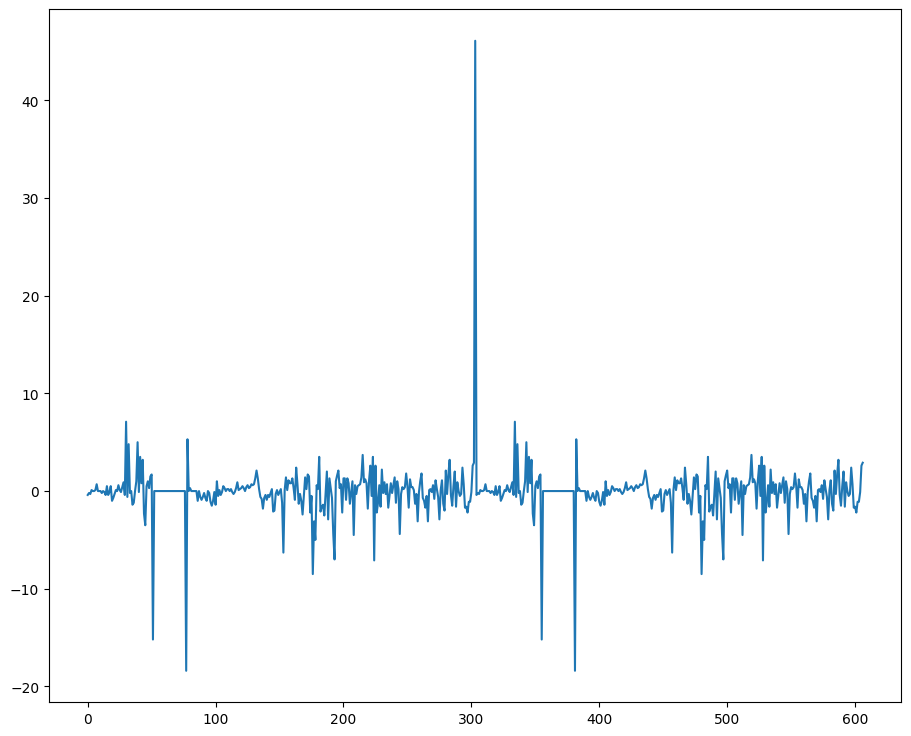

In [83]:
plt.plot(nottrend)

In [84]:
stationarity_check(nottrend, name="ts without trend")

Тест Дики-Фуллера ряда ts without trend :
Test Statistic                -1.623634e+01
p-value                        3.766535e-29
#Lags Used                     1.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (1%)           -3.441205e+00
Critical Value (5%)           -2.866329e+00
Critical Value (10%)          -2.569320e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


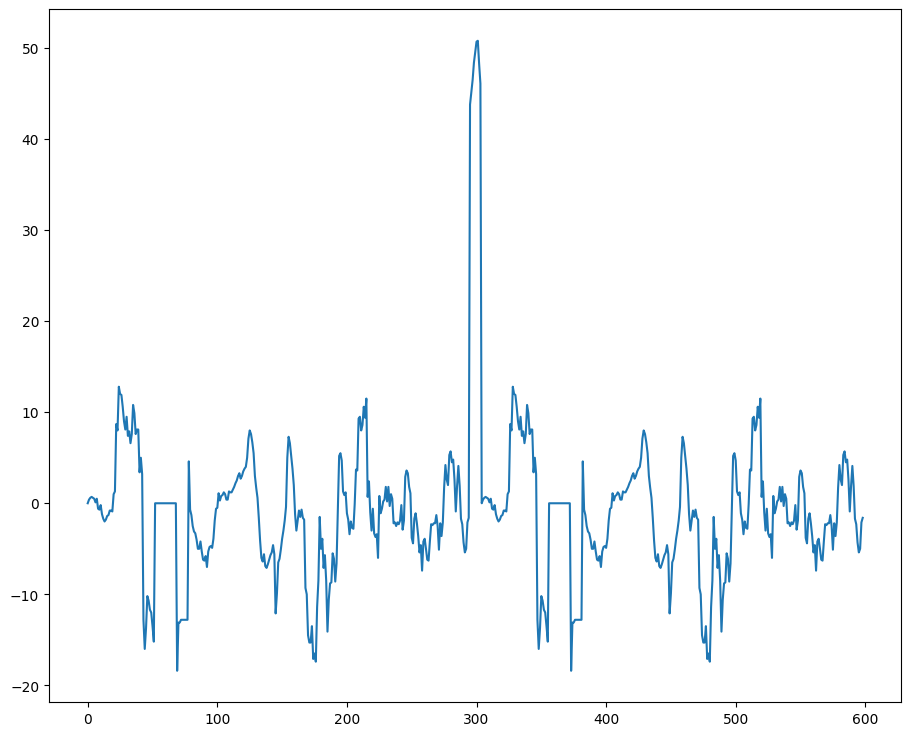

In [85]:
notseason = get_ts_without_season(df["value"], 9)
plt.plot(notseason)

In [86]:
stationarity_check(notseason, name="ts without season")

Тест Дики-Фуллера ряда ts without season :
Test Statistic                  -3.980219
p-value                          0.001518
#Lags Used                      18.000000
Number of Observations Used    580.000000
Critical Value (1%)             -3.441675
Critical Value (5%)             -2.866536
Critical Value (10%)            -2.569431
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Коксим-Боксим

best_lambda: 0.36301022368972186


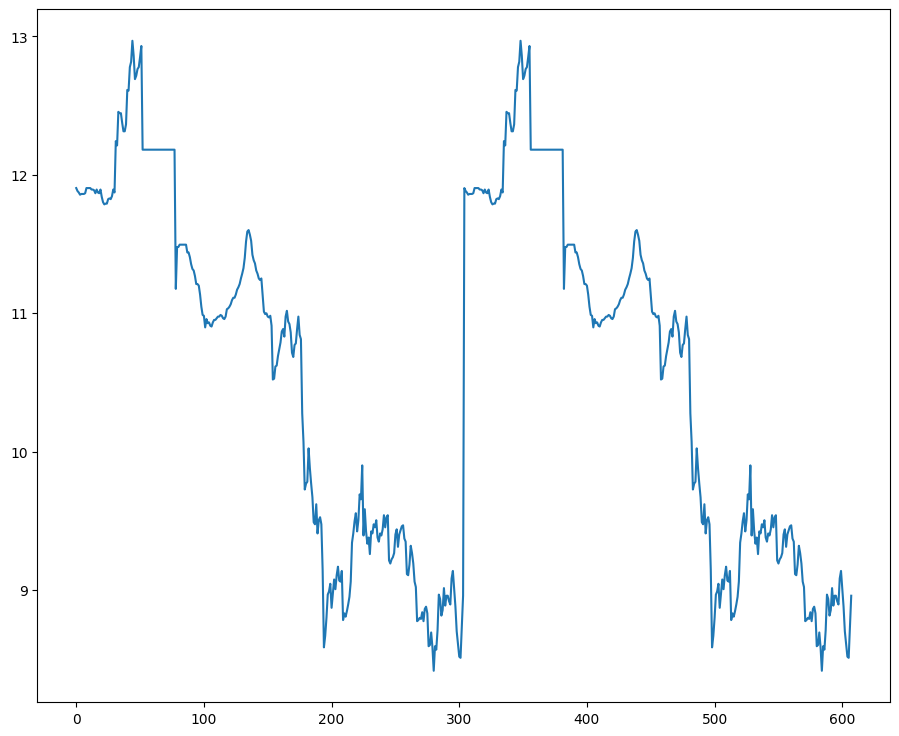

In [88]:

from scipy.stats import boxcox 

transformed_data, best_lambda = boxcox(df["value"]) 
print(f"best_lambda: {best_lambda}")
# а теперь посмотрим на преобразованные данные
plt.plot(transformed_data) 

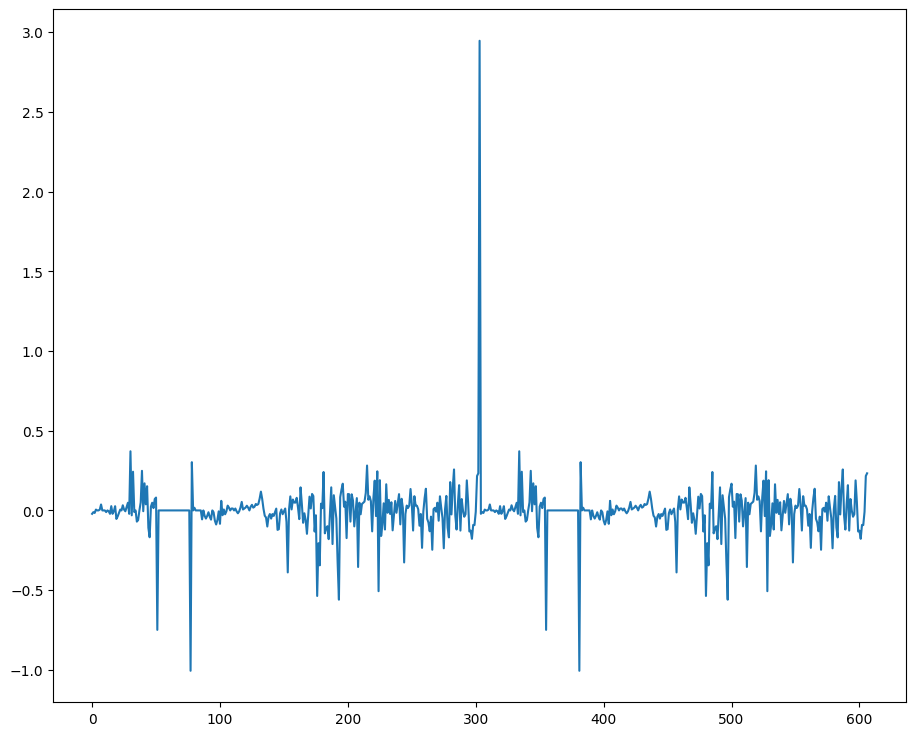

In [89]:
transform_nottrend = get_ts_without_trend(transformed_data)
plt.plot(transform_nottrend)

In [90]:
# проверка на стационарность измененного ряда без тренда

stationarity_check(transform_nottrend, name="transform_nottrend")

Тест Дики-Фуллера ряда transform_nottrend :
Test Statistic                -1.596724e+01
p-value                        7.069603e-29
#Lags Used                     1.000000e+00
Number of Observations Used    6.050000e+02
Critical Value (1%)           -3.441205e+00
Critical Value (5%)           -2.866329e+00
Critical Value (10%)          -2.569320e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Модели для предсказания значений временного ряда

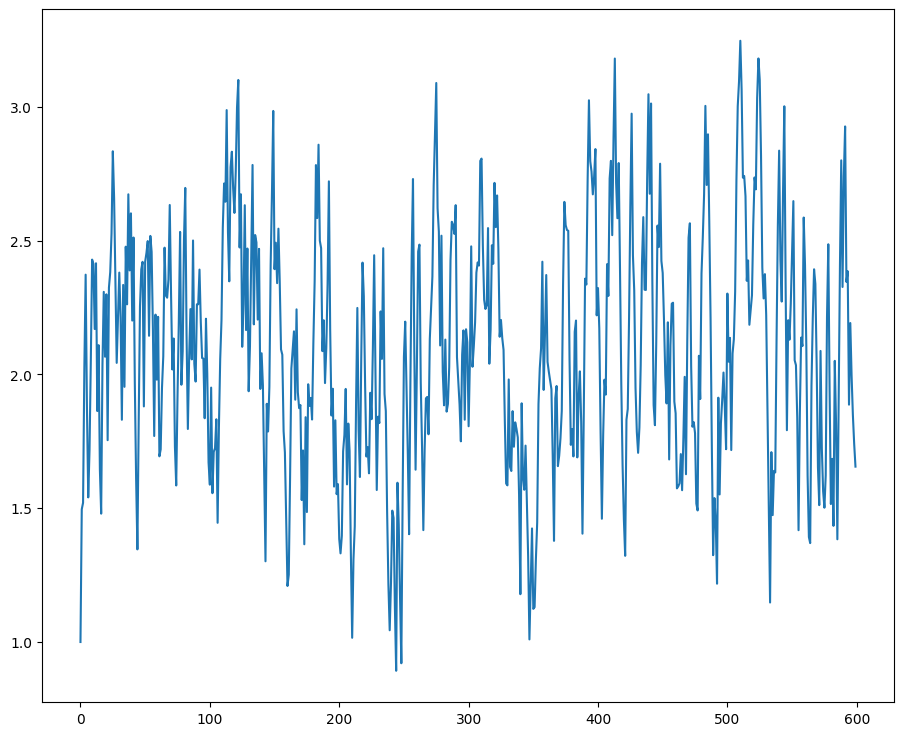

In [91]:
# AR(1)

N = 600

ar1 = [1]
for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())

plt.plot(ar1)

In [92]:
print(f"standart deviation = {np.std(ar1)}\nmean = {np.mean(ar1)}")

standart deviation = 0.4449369435548613
mean = 2.090952760724296


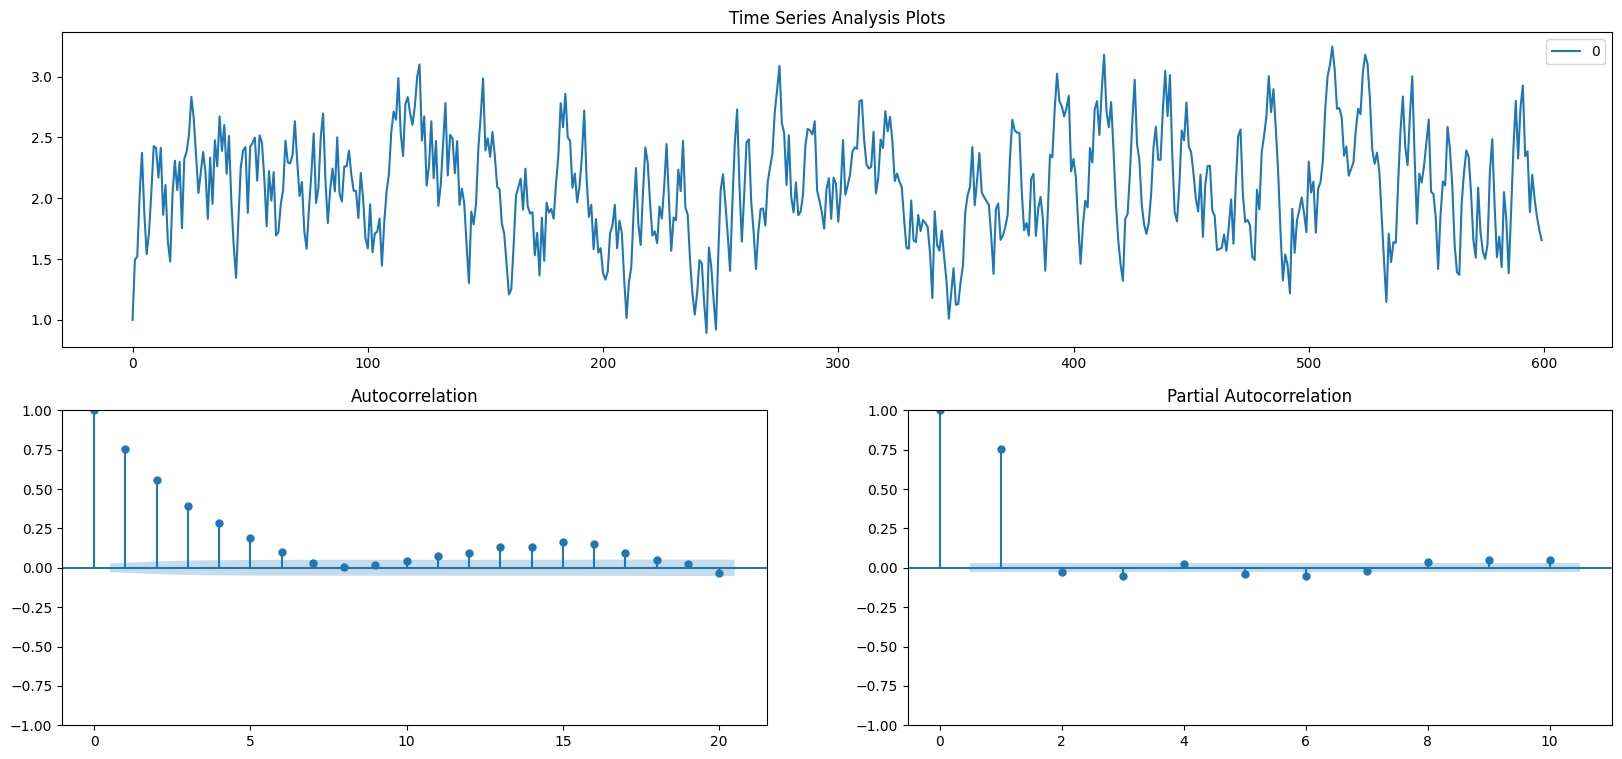

In [93]:
# transform to dataframe
ts = pd.DataFrame(ar1)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

### ряд с отрицательными значениями коэффициента

standart deviation = 0.4647240193558899
mean = 0.27772793559251113


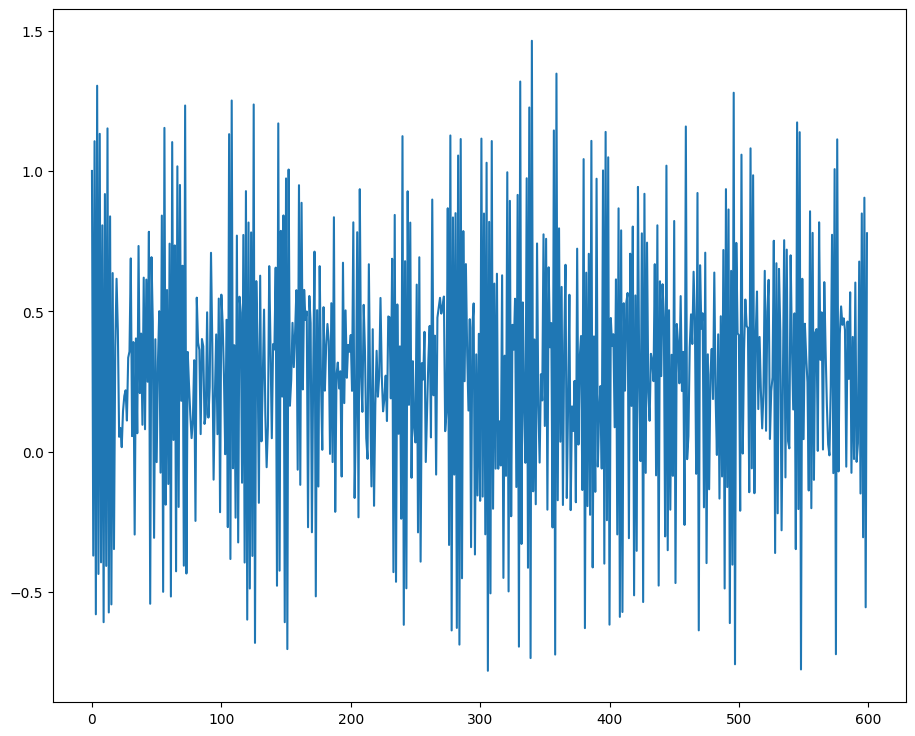

In [60]:
# AR(1)

N = 600

ar2 = [1]

for i in range(1, N):
    ar2.append(- 0.76*ar2[i-1] + np.random.random())

plt.plot(ar2)

print(f"standart deviation = {np.std(ar2)}\nmean = {np.mean(ar2)}")

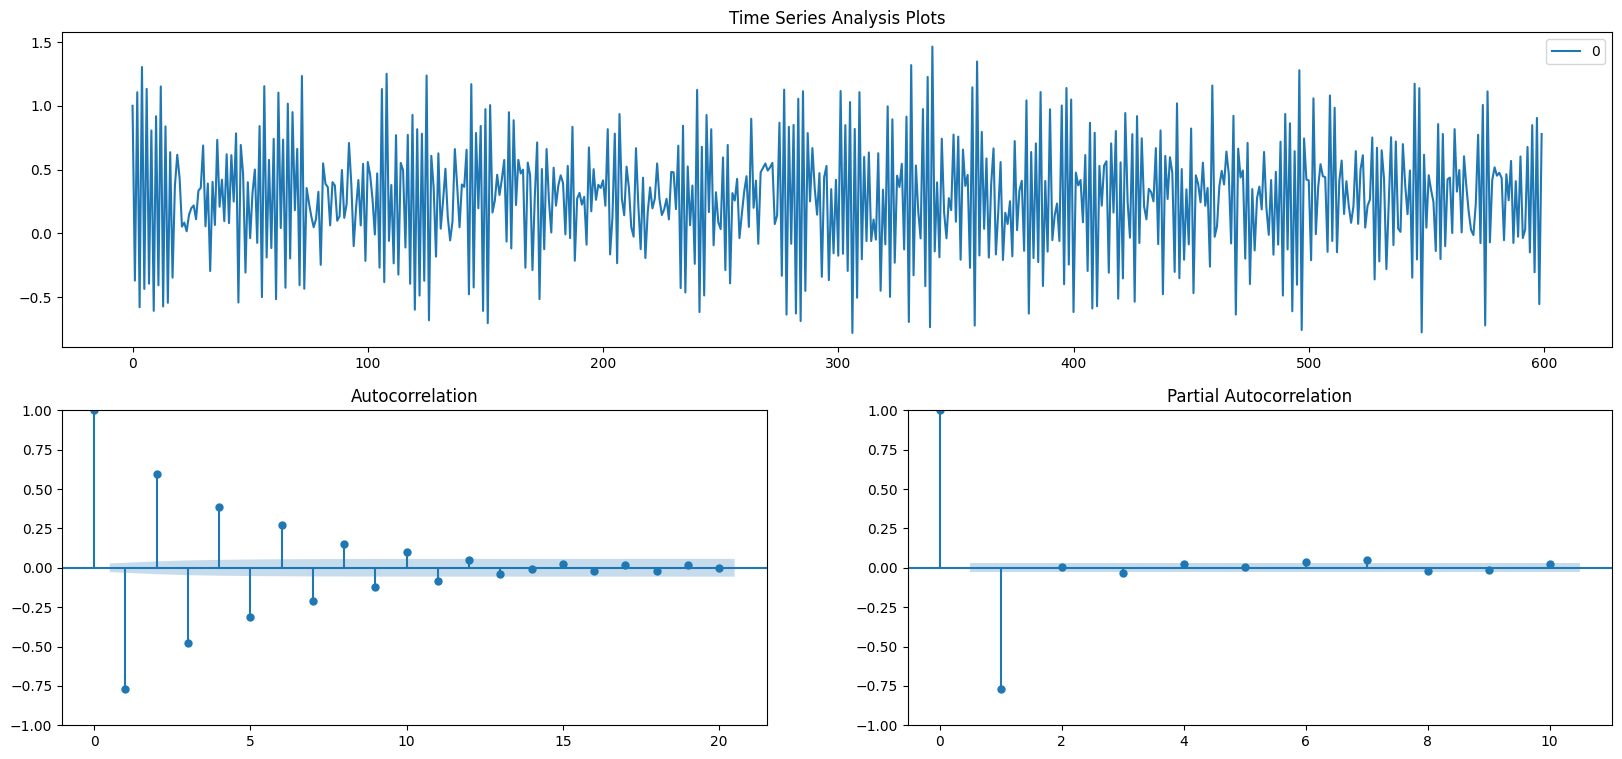

In [61]:
ts = pd.DataFrame(ar2)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

### Коэффициент >1

standart deviation = 0.4647240193558899
mean = 0.27772793559251113


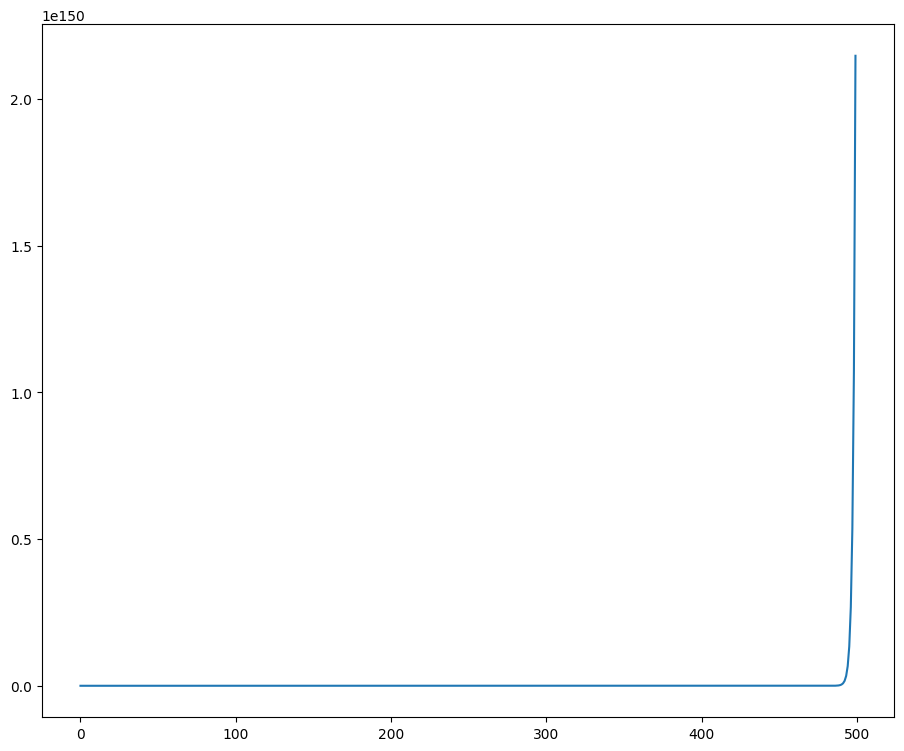

In [63]:
# AR(1)

N = 500

ar3 = [1]

for i in range(1, N):
    ar3.append(2 * ar3[i-1] + np.random.random())

plt.plot(ar3)

print(f"standart deviation = {np.std(ar2)}\nmean = {np.mean(ar2)}")

## Прогнозирование

In [95]:
base_dir = os.path.abspath(os.curdir) + r'/data'
df = pd.read_csv(path.join(os.sep, base_dir, 'Exchange Rate TWI May 1970  Aug 1995.csv'), names=["n","x"], skiprows=1)
df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

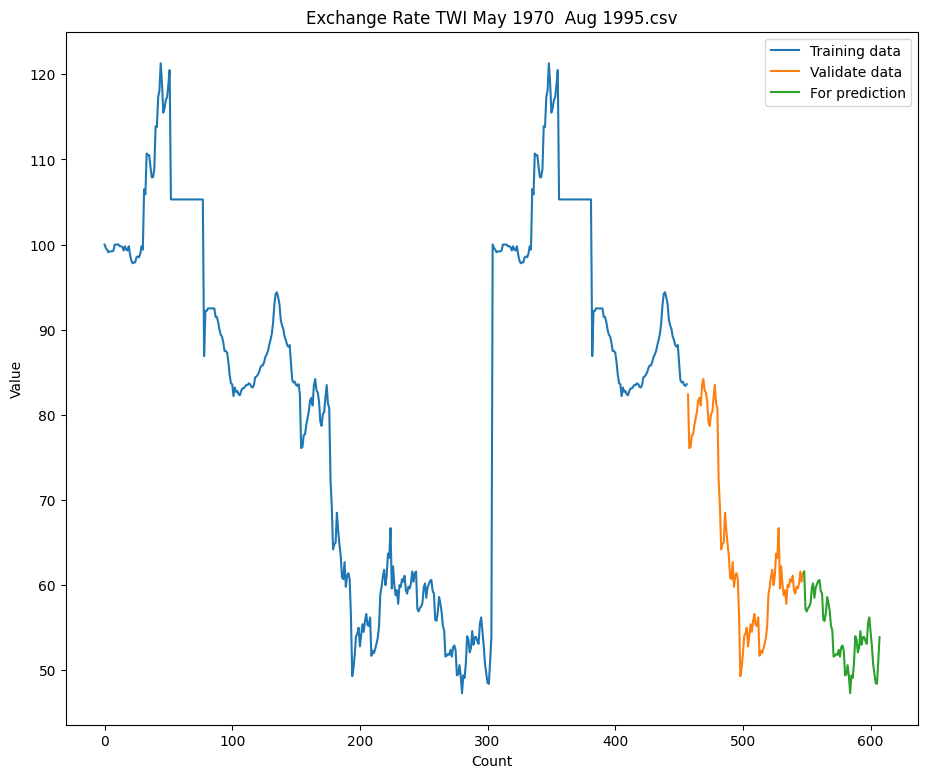

In [96]:
# Визуализация выборок

plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Exchange Rate TWI May 1970  Aug 1995.csv')
plt.ylabel('Value')
plt.xlabel('Count')
plt.show()

In [97]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [98]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(df.t, 3, old_names=False)

res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  608
Model:                     AutoReg(3)   Log Likelihood               15081.860
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 13 Oct 2023   AIC                         -30153.719
Time:                        13:00:26   BIC                         -30131.693
Sample:                             3   HQIC                        -30145.148
                                  608                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   9.78e-14   6.82e+12      0.000       0.667       0.667
t.L1           1.0000   9.75e-14   1.03e+13      0.000       1.000       1.000
t.L2           0.3333    2.8e-16   1.19e+15      0.0

In [99]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  608
Model:                     AutoReg(1)   Log Likelihood               -1493.986
Method:               Conditional MLE   S.D. of innovations              2.836
Date:                Fri, 13 Oct 2023   AIC                           2993.972
Time:                        13:00:36   BIC                           3007.197
Sample:                             1   HQIC                          2999.118
                                  608                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6559      0.456      1.438      0.150      -0.238       1.550
x.L1           0.9907      0.006    176.504      0.000       0.980       1.002
                                    Roots           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


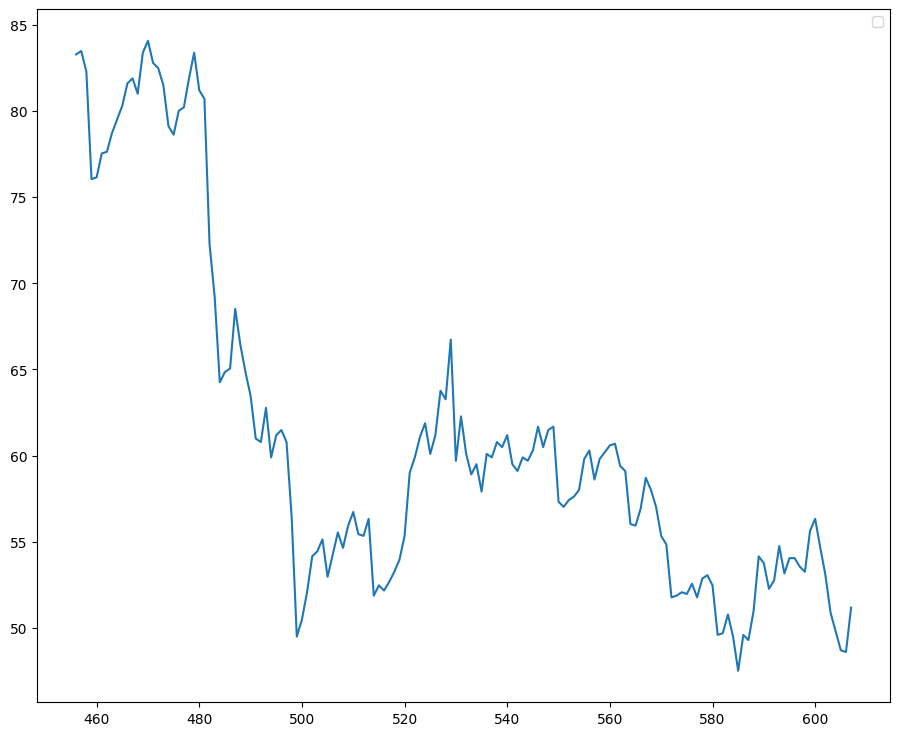

In [100]:
fig = res.plot_predict(train_cutoff)

In [101]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

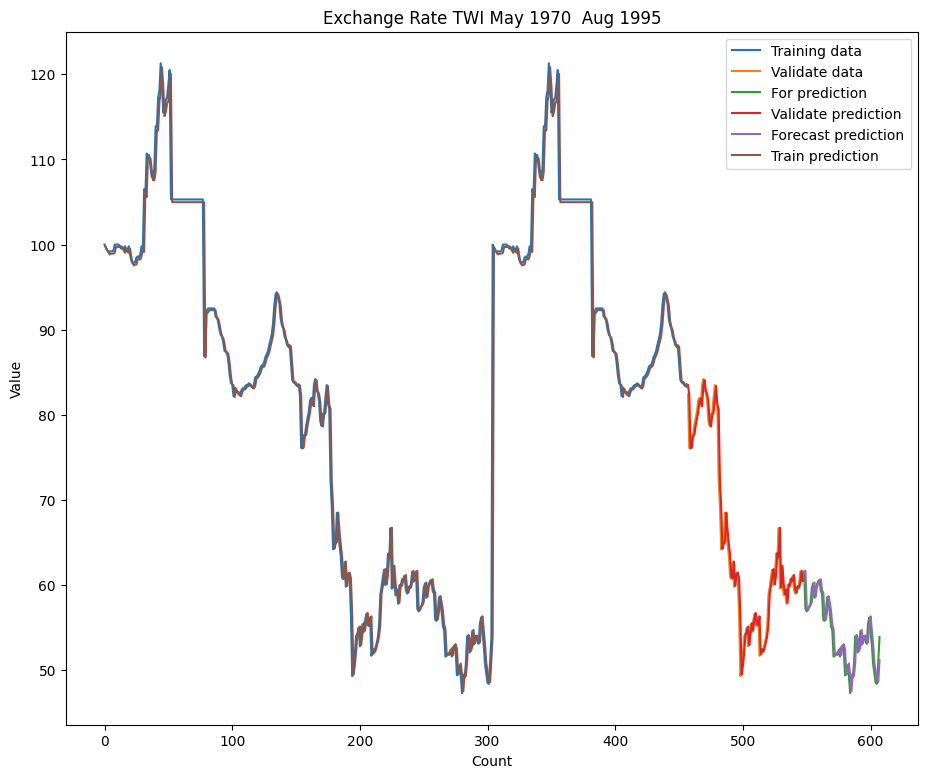

In [102]:

plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Exchange Rate TWI May 1970  Aug 1995')
plt.ylabel('Value')
plt.xlabel('Count')
plt.show()

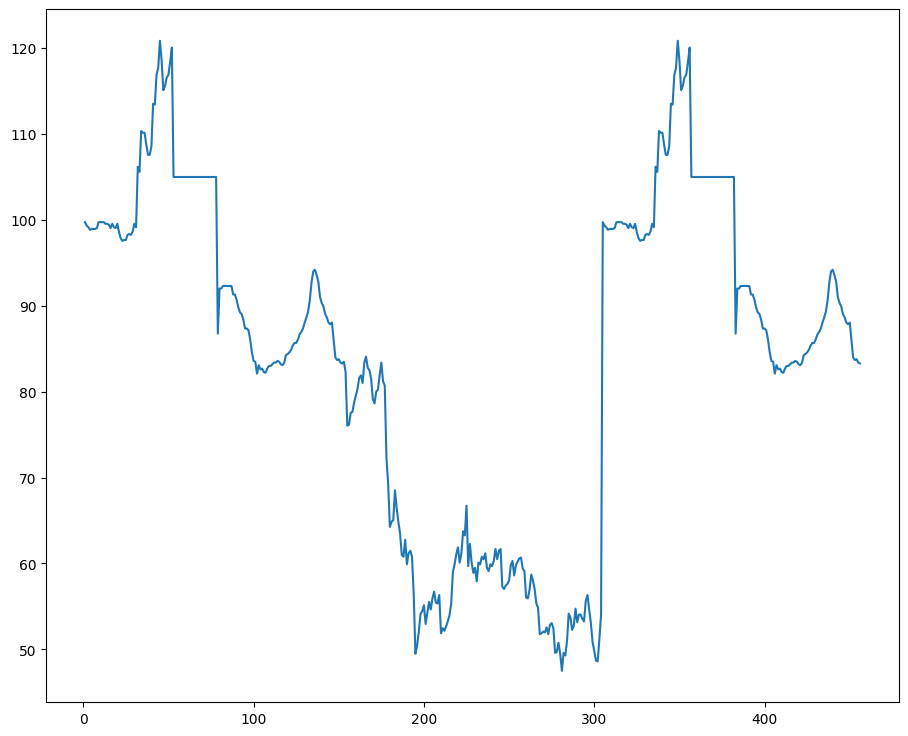

In [103]:
plt.plot(pred)

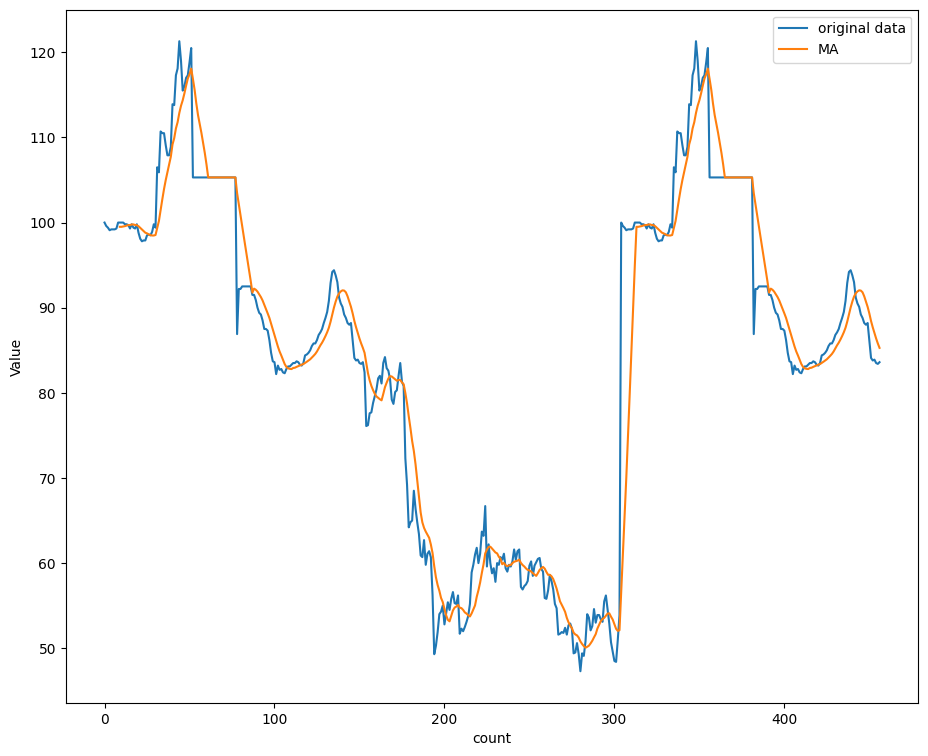

In [104]:
# MA

df['t'] = df.index.values

ln = len(df)


train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))


train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Value')
plt.xlabel('count')
plt.show()

## Метрики точности прогноза

In [107]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [108]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))

RMSE: 1.5271484882500974
MAPE: 0.021681579712238438
MAE: 1.160895330495634
R2:  0.8247151098400591
